基于环境反馈的控制方法，叫做反馈控制。

控制模块的目的是让无人车能够按照规划好的路径行驶，需要将环境当前的反馈和规划的参考量进行比较，得到当前偏离参考量的误差，并基于这个误差设计一定的算法来产生输出信号，使得误差不断变小，直到为0.

PID控制器是目前应用最广泛的控制理论。

PID控制器是指P(Proportion 比例)、I（Integral 积分），D(Derivative 微分) ，这三项如何使用误差来产生控制指令。

1. P控制

假设控制输出的是车辆的转角；

偏离航迹误差(Cross Track Error, CTE):就是车辆到参考线的距离，用CTE作为误差度量,即转向角与CTE成比例；

$$ 
sterring angle = K_p *e(t)
$$

e(t)是车辆在t时刻的CTE，CTE偏大时，转向角也大，反之偏转小一点；

在P控制器中，系数$K_p$会直接影响实际控制效果，在合理范围内，$K_p$越大，控制效果越好。

伪代码实现：

```
def run(robot, tau, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    for i in range(n):
        cte = robot.y
        steer = -tau * cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    return x_trajectory, y_trajectory
```

但是P控制器容易受零值影响，实际中表现为来回多次穿过参考线

![](./P_Control.png)

为了矫正这个问题，我们引入一个新的参数，CTE变化率

# 2. PD控制

CTE的变化率，描述无人车向着参考线移动的多块，如果无人车一直在参考线上运动，CTE变化率就是0；

$$
steering angle = K_p*e(t) + K_d\frac{de(t)}{dt}
$$

增大P系数会增大无人车向参考线运动的倾向，增大D系数则会增大无人车转向角快速变化的“阻尼”；

对于P偏大，D偏小的系统，称为“欠阻尼系统(underdamped)”, 这种情况无人车将沿参考线震荡前行；

而P偏小，D偏大的系统，称为“过阻尼(overdamped)”，这使得无人车需较长时间才能纠正误差；

合适的P，D系数，可以使无人车快速回到参考线，同时很好维持在参考线运动；

伪代码实现：

```
def run(robot, tau_p, tau_d, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    prev_cte = robot.y
    for i in range(n):
        cte = robot.y
        diff_cte = cte - prev_cte
        prev_cte = cte
        steer = -tau_p * cte - tau_d * diff_cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    return x_trajectory, y_trajectory
```

![](./pd.png)

# 系统偏差

PD控制器可以保证正常的控制需求，但是容易受系统偏差影响；

比如当车轮存在偏移角(非理想化)，对人类驾驶来说，这问题不大，但是对于无人驾驶，会产生巨大的CTE。

为解决熊偏差问题，引入一个控制量来消除这种误差。

# PID控制器

引入一个积分项，加入到控制输出函数中

$$
steering angle = K_p*e(t) + K_d\frac{de(t)}{dt} + k_i\int_0^te(t)dt
$$

$K_i$积分项，本质上是车的实际路线和参考线的图形面积，加入积分项后，控制器会使车辆路线的积分尽可能小，从而避免稳态误差情况。

伪代码实现:

```
def run(robot, tau_p, tau_d, tau_i, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    prev_cte = robot.y
    int_cte = 0
    for i in range(n):
        cte = robot.y
        diff_cte = cte - prev_cte
        prev_cte = cte
        int_cte += cte
        steer = -tau_p * cte - tau_d * diff_cte - tau_i * int_cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    return x_trajectory, y_trajectory
```

积分向系数的大小也会影响整个控制系统的稳定性，$K_i$过大，会使系统“震荡”运行，$K_i$过小又会需要较长时间才能修正车辆稳态误差。

![](./pid.png)

PID控制器，就是由$K_p, K_i, K_d$三项共同决定的，其实现非常简单，但是这三个系数的选择缺很难。

PID算法Python实现：

In [3]:
# -----------
# User Instructions
#
# Implement a P controller by running 100 iterations
# of robot motion. The steering angle should be set
# by the parameter tau so that:
#
# steering = -tau_p * CTE - tau_d * diff_CTE - tau_i * int_CTE
#
# where the integrated crosstrack error (int_CTE) is
# the sum of all the previous crosstrack errors.
# This term works to cancel out steering drift.
#
# Only modify code at the bottom! Look for the TODO.
# ------------

import random
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------
# 
# this is the Robot class
#

class Robot(object):
    def __init__(self, length=20.0):
        """
        Creates robot and initializes location/orientation to 0, 0, 0.
        """
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    def set(self, x, y, orientation):
        """
        Sets a robot coordinate.
        """
        self.x = x
        self.y = y
        self.orientation = orientation % (2.0 * np.pi)

    def set_noise(self, steering_noise, distance_noise):
        """
        Sets the noise parameters.
        """
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = steering_noise
        self.distance_noise = distance_noise

    def set_steering_drift(self, drift):
        """
        Sets the systematical steering drift parameter
        """
        self.steering_drift = drift

    def move(self, steering, distance, tolerance=0.001, max_steering_angle=np.pi / 4.0):
        """
        steering = front wheel steering angle, limited by max_steering_angle
        distance = total distance driven, most be non-negative
        """
        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = np.tan(steering2) * distance2 / self.length

        if abs(turn) < tolerance:
            # approximate by straight line motion
            self.x += distance2 * np.cos(self.orientation)
            self.y += distance2 * np.sin(self.orientation)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
        else:
            # approximate bicycle model for motion
            radius = distance2 / turn
            cx = self.x - (np.sin(self.orientation) * radius)
            cy = self.y + (np.cos(self.orientation) * radius)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
            self.x = cx + (np.sin(self.orientation) * radius)
            self.y = cy - (np.cos(self.orientation) * radius)

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]' % (self.x, self.y, self.orientation)

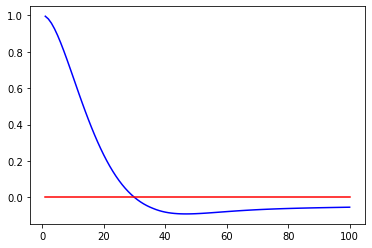

In [4]:
############# ADD / MODIFY CODE BELOW ####################
# ------------------------------------------------------------------------
#
# run - does a single control run

robot = Robot()
robot.set(0, 1, 0)


def run(robot, tau_p, tau_d, tau_i, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    prev_cte = robot.y
    int_cte = 0
    for i in range(n):
        cte = robot.y
        diff_cte = cte - prev_cte
        prev_cte = cte
        int_cte += cte
        steer = -tau_p * cte - tau_d * diff_cte - tau_i * int_cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    return x_trajectory, y_trajectory

x_trajectory, y_trajectory = run(robot, 0.2, 3.0, 0.001)
n = len(x_trajectory)

plt.plot(x_trajectory, y_trajectory, 'b', label='PID controller')
plt.plot(x_trajectory, np.zeros(n), 'r', label='reference')
plt.savefig("PID_Contrl.png")

# PID系数调整方法：

## 1.twiddle算法：

如上例PID算法实现，返回一个CTE的平均值来度量系统的误差程度，问题转化为，寻找使CTE均值最小化的PID系数。

设立一组初始值, 比如系数初值p=[0, 0, 0]; 系数调整范围初值dp=[1,1,1]

循环遍历迭代系数p，

首先调大p[i]值，p[i] += dp[i] 

若效果改善，保留该值，将对应系数范围加大dp[i]*=1.1

若无改善，调小p[i], p[i] -= 2*dp[i] ;

若有效，保留该值，将对应系数范围加大dp[i]*=1.1

若无效，p[i]保留原值，缩小dp[i]范围 dp[i]*=1.1；

循环迭代，通过缩放得到的参数越来越精确，直到收敛(系数范围和sum(dp[i])足够小).

这是一种局部爬山算法，但是它非常高效.


伪代码实现：

```
def twiddle(tol=0.2): 
    p = [0, 0, 0]
    dp = [1, 1, 1]
    robot = make_robot()
    x_trajectory, y_trajectory, best_err = run(robot, p)

    it = 0
    while sum(dp) > tol:
        print("Iteration {}, best error = {}".format(it, best_err))
        for i in range(len(p)):
            p[i] += dp[i]
            robot = make_robot()
            x_trajectory, y_trajectory, err = run(robot, p)

            if err < best_err:
                best_err = err
                dp[i] *= 1.1
            else:
                p[i] -= 2 * dp[i]
                robot = make_robot()
                x_trajectory, y_trajectory, err = run(robot, p)

                if err < best_err:
                    best_err = err
                    dp[i] *= 1.1
                else:
                    p[i] += dp[i]
                    dp[i] *= 0.9
        it += 1
    return p
```


![](./twiddle.png)

# Additional Resources on Control

Model Predictive Control (MPC)

Vision-Based High Speed Driving with a Deep Dynamic Observer by P. Drews, et. al.
https://arxiv.org/abs/1812.02071

Abstract: In this paper we present a framework for combining deep learning-based road detection, particle filters, and Model Predictive Control (MPC) to drive aggressively using only a monocular camera, IMU, and wheel speed sensors. This framework uses deep convolutional neural networks combined with LSTMs to learn a local cost map representation of the track in front of the vehicle. A particle filter uses this dynamic observation model to localize in a schematic map, and MPC is used to drive aggressively using this particle filter based state estimate. We show extensive real world testing results, and demonstrate reliable operation of the vehicle at the friction limits on a complex dirt track. We reach speeds above 27 mph (12 m/s) on a dirt track with a 105 foot (32m) long straight using our 1:5 scale test vehicle. [...]

## Reinforcement Learning-based

Reinforcement Learning and Deep Learning based Lateral Control for Autonomous Driving by D. Li, et. al.
https://arxiv.org/abs/1810.12778


https://arxiv.org/abs/1810.12778

Abstract: This paper investigates the vision-based autonomous driving with deep learning and reinforcement learning methods. Different from the end-to-end learning method, our method breaks the vision-based lateral control system down into a perception module and a control module. The perception module which is based on a multi-task learning neural network first takes a driver-view image as its input and predicts the track features. The control module which is based on reinforcement learning then makes a control decision based on these features. In order to improve the data efficiency, we propose visual TORCS (VTORCS), a deep reinforcement learning environment which is based on the open racing car simulator (TORCS). By means of the provided functions, one can train an agent with the input of an image or various physical sensor measurement, or evaluate the perception algorithm on this simulator. The trained reinforcement learning controller outperforms the linear quadratic regulator (LQR) controller and model predictive control (MPC) controller on different tracks. The experiments demonstrate that the perception module shows promising performance and the controller is capable of controlling the vehicle drive well along the track center with visual input.

## Behavioral Cloning

The below paper shows one of the techniques Waymo has researched using imitation learning (aka behavioral cloning) to drive a car.

ChauffeurNet: Learning to Drive by Imitating the Best and Synthesizing the Worst by M. Bansal, A. Krizhevsky and A. Ogale

https://arxiv.org/abs/1812.03079

Abstract: Our goal is to train a policy for autonomous driving via imitation learning that is robust enough to drive a real vehicle. We find that standard behavior cloning is insufficient for handling complex driving scenarios, even when we leverage a perception system for preprocessing the input and a controller for executing the output on the car: 30 million examples are still not enough. We propose exposing the learner to synthesized data in the form of perturbations to the expert's driving, which creates interesting situations such as collisions and/or going off the road. Rather than purely imitating all data, we augment the imitation loss with additional losses that penalize undesirable events and encourage progress -- the perturbations then provide an important signal for these losses and lead to robustness of the learned model. We show that the ChauffeurNet model can handle complex situations in simulation, and present ablation experiments that emphasize the importance of each of our proposed changes and show that the model is responding to the appropriate causal factors. Finally, we demonstrate the model driving a car in the real world.
